In [6]:
from pydub import AudioSegment
from pydub.utils import mediainfo
from scipy import spatial
from glob import glob
from IPython.display import Audio
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import h5py
import datetime
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
%matplotlib inline

In [14]:
f = h5py.File("whole.hdf5", "r")
f['135054'][...]

array([0.        , 0.        , 0.        , ..., 0.3353679 , 0.33838923,
       0.34501175])

In [106]:
targets = [2,3,1,0]
np.eye(4)[targets]

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

In [123]:
Fs = 44100
LENGTH = Fs
channel = 2**8

def encode(batch):
    mu = np.float32(channel-1)
    safe_batch = np.minimum(abs(batch), 1.0)
    output = np.sign(batch) * np.log1p(mu * safe_batch) / np.log1p(mu)
    output = np.int32((output + 1) / 2 * mu + 0.5)
    output = np.eye(channel)[output]
    return output

def get_batch(f, k):
    
    batch = []
    label = []
    
    songs = np.random.choice(len(f), k)
    
    for i in range(len(songs)):
        cur_label = list(f)[songs[i]]
        start = np.random.choice(len(f[cur_label])-LENGTH, 1)[0]
        segment = f[cur_label][start:start+LENGTH]
        batch.append(segment)
        label.append(int(cur_label))
        
    batch = np.asarray(batch)
    batch = batch/max(np.amax(batch),-np.amin(batch)) 
    batch = encode(batch)
    label = np.asarray(label)
        
    return batch, label

In [124]:
train_data, train_label = get_batch(f,2)
train_data.shape

(2, 44100, 256)

In [132]:
dilation_rates = [2**i for i in range(8)]*2
receptive_field = sum(dilation_rates)+2

def WaveNet(x):
    # save copy of input
    original = x
    
    # discard last sample to preserve causality
    x = tf.slice(x, [0,0,0], [-1,LENGTH-1,-1])
    
    # preprocessing causal layer
    x = tf.layers.conv1d(
        inputs=x,
        filters=16,
        kernel_size=2,
        padding="causal",
        activation=tf.nn.relu)
    
    skips = []
    
    for dilation_rate in dilation_rates:
        
        # filter
        x_f = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.tanh)
        
        # gate
        x_g = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.sigmoid)
        
        # element wise multiplication
        z = tf.multiply(x_f,x_g)
        
        # skip cut to account for receptive field
        skip = tf.slice(z, [0,receptive_field-1,0], [-1,-1,-1])

        # skip postprocessing
        skip = tf.layers.conv1d(
            inputs=skip,
            filters=32,
            kernel_size=1,
            padding="same",
            activation=tf.nn.relu)
        
        # residual postprocessing
        z = tf.layers.conv1d(
            inputs=z,
            filters=16,
            kernel_size=1,
            padding="same",
            activation=tf.nn.relu)
        
        # residual connection
        x = tf.add(x,z)
        
        # skip append
        skips.append(skip)
    
    # add all skip layers and apply activation
    out = tf.add_n(skips)
    out = tf.nn.relu(out)
    
    # postprocessing
    out = tf.layers.conv1d(
            inputs=out,
            filters=128,
            kernel_size=1,
            padding="same",
            activation=tf.nn.relu)
    
    # dropout layer
    out = tf.layers.dropout(
            inputs=out,
            rate=0.2)
    
    # compress to one channel output
    out = tf.layers.conv1d(
            inputs=out,
            filters=channel,
            kernel_size=1,
            padding="same")

    # perform softmax
    prediction = tf.reshape(out, [-1,channel])
    target = tf.slice(original, [0,receptive_field,0], [-1,-1,-1])
    target = tf.reshape(target, [-1,channel])
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(
            logits=prediction,
            labels=target)
    loss = tf.reduce_mean(loss)

    return loss

In [133]:
tf.reset_default_graph()

input_data = tf.placeholder(tf.float32, [2, LENGTH, channel])
input_label = tf.placeholder(tf.int32, [2])

# loss function operations
loss = WaveNet(input_data)

# train operation
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(
    loss=loss,
    global_step=tf.train.get_global_step())
init = tf.global_variables_initializer()

In [134]:
saver = tf.train.Saver()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)
loss_hist = []
#saver.restore(sess, "../model/model1.ckpt")

In [135]:
num_epoch = 1500
start = datetime.datetime.now()
for i in range(num_epoch):
    train_data, train_label = get_batch(f,2)
    _, loss_val = sess.run([train_op, loss],
                           feed_dict={input_data: train_data,
                                      input_label: train_label})
    loss_hist.append(loss_val)
    #if i % 10 == 0:
    print('iter num: '+str(i)+' loss: '+str(loss_hist[-1]))
end = datetime.datetime.now()
print('time: '+str(end-start))

iter num: 0 loss: 5.5747175
iter num: 1 loss: 5.5454125
iter num: 2 loss: 5.5325246
iter num: 3 loss: 5.524248
iter num: 4 loss: 5.5215592
iter num: 5 loss: 5.505817
iter num: 6 loss: 5.4785843
iter num: 7 loss: 5.515971
iter num: 8 loss: 5.4988413
iter num: 9 loss: 5.439656


KeyboardInterrupt: 

In [136]:
save_path = saver.save(sess, "../model/WaveNet.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: ../model/WaveNet.ckpt


Text(0.5, 1.0, 'loss history')

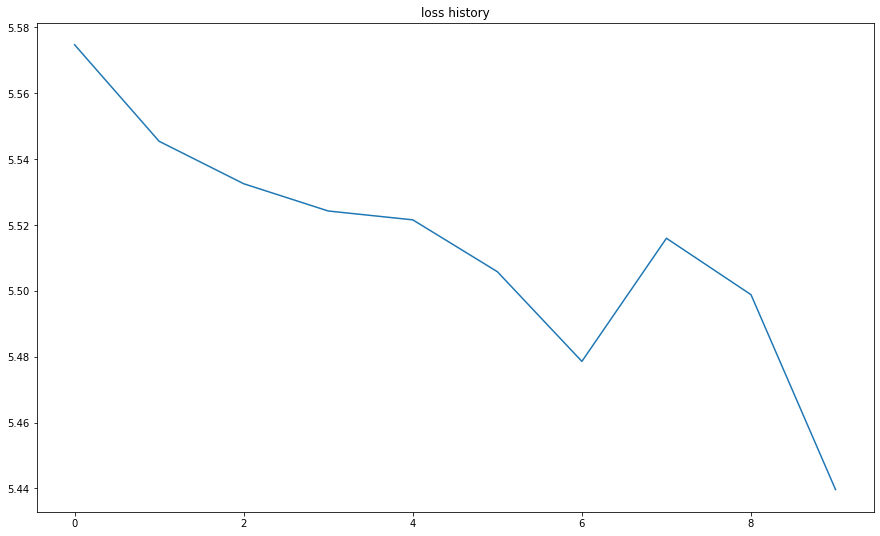

In [137]:
plt.figure(figsize=(15,9))
plt.plot(loss_hist)
plt.title('loss history')

In [138]:
tvars = tf.trainable_variables()
tvars_vals = sess.run(tvars)
for var, val in zip(tvars, tvars_vals):
    print(var.name, val) 

conv1d/kernel:0 [[[-0.00764302  0.08514422 -0.05065309 ...  0.0379135   0.06906301
   -0.03381749]
  [-0.0313404   0.06128222 -0.0114218  ... -0.01125646  0.04178394
   -0.01999244]
  [-0.06366739 -0.01996886 -0.10469883 ... -0.06203692 -0.075432
   -0.07599211]
  ...
  [-0.05886288 -0.03702269  0.07333543 ... -0.031183   -0.06246213
   -0.07807533]
  [ 0.06939906 -0.02685037  0.00917304 ...  0.07779755 -0.10350447
    0.03129969]
  [-0.05322932 -0.06305284 -0.09948529 ...  0.01833452 -0.07522689
   -0.07949632]]

 [[ 0.06119525  0.05663824 -0.0229872  ... -0.09987775 -0.03630451
   -0.01221003]
  [-0.03337803  0.04303232 -0.07940888 ...  0.08365687  0.06692252
   -0.09567056]
  [-0.05300125 -0.03382091  0.01312537 ...  0.0316399   0.02917697
    0.09897753]
  ...
  [-0.03205038 -0.09749124  0.01417284 ...  0.03074039  0.05612262
    0.03777957]
  [ 0.0758367   0.07163057 -0.09251386 ...  0.08221868  0.07763551
    0.01036897]
  [ 0.06165757 -0.04231352  0.00068492 ... -0.0969816  -0.0

conv1d_15/kernel:0 [[[ 0.08963599 -0.22565967 -0.12783043 ...  0.2860076   0.11423583
   -0.05271988]
  [ 0.19953114  0.2684026   0.06057053 ...  0.12575531  0.21134765
   -0.06718211]
  [-0.23223525  0.07598089 -0.12158532 ... -0.15291597 -0.12447505
    0.28946558]
  ...
  [ 0.21086471  0.17528911 -0.12038923 ... -0.1721234   0.06156157
   -0.00573028]
  [ 0.17251314  0.1430351  -0.13527866 ... -0.02914556 -0.27225956
    0.15457955]
  [-0.12195386  0.02307175  0.27742457 ...  0.16915953 -0.18945488
   -0.02573652]]]
conv1d_15/bias:0 [ 0.00322376 -0.00860385 -0.00626512  0.00920312 -0.00871294 -0.00632767
 -0.00134563  0.00157318  0.00867144  0.00448215 -0.00149055  0.01020894
 -0.00561981  0.00466194  0.00332691 -0.0094882   0.00925534 -0.00025207
 -0.00518185 -0.00817356  0.00069624 -0.00926608  0.0062798   0.01031701
 -0.00176631  0.0097621   0.00942397 -0.00875144  0.00801522 -0.0077652
  0.00129389 -0.00622839]
conv1d_16/kernel:0 [[[-0.15760338  0.09291838  0.30453014  0.3401674

In [139]:
tf.test.is_gpu_available()

False